# Point72 Global Futures Analysis

Diego Alvarez <br> diego.alvarez@colorado.edu

# Background

Rather than creating an object and then methods for the object, functions will be defined as problems / tasks occur so that the flow of the notebook is easier to follow. The caveat that comes with this a majority of functions will take in the raw prices data, which implies a significant amoun to of parametrization. For example a function (func1) may calculate a statistic based on the raw data, if another function (func2) is written to plot that output it will require raw price data and then use func1. This parametrization is costly / time consuming but the code can easily be modified and rewritten for OOP.

# Packages

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

np.random.seed(123)

# Accessing Data

## Path Management

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
price_path = os.path.join(data_path, "prices.parquet")
price_sample_path = os.path.join(data_path, "prices_samples.parquet")

## Reading in Data

In [3]:
try: df_price = pd.read_parquet(path = price_path, engine = "pyarrow")
except: df_price = pd.read_parquet(path = price_sample_path, engine = "pyarrow") 

# Metadata

Check for duplicates 

In [4]:
def check_duplicates(df: pd.DataFrame):

    df_duplicates = (df.groupby(
        ["contract_name", "local_time"]).
        agg("count").
        reset_index().
        melt(id_vars = ["contract_name", "local_time"]).
        query("value != 1"))

    if len(df_duplicates) == 0: print("No Duplicates Detected")
    else: print("Duplicates Detected")
    
check_duplicates(df_price)

No Duplicates Detected


Look at data count in total with start and stop

In [5]:
def get_count(df: pd.DataFrame):

    display(df[
        ["contract_name", "local_time"]].
        groupby(["contract_name"]).
        agg(["min", "max", "count"])
        ["local_time"])
    
get_count(df_price)

,min,max,count
contract_name,,,
Chicago1,2013-01-01 00:00:00,2022-12-31 18:00:00,1051585
Frankfurt1,2013-01-01 01:00:00,2022-12-31 23:55:00,1051524
London1,2013-01-01 00:00:00,2022-12-31 23:55:00,1051536
NYC1,2013-01-01 00:00:00,2022-12-31 19:00:00,1051597
Tokyo1,2013-01-01 09:00:00,2022-12-31 23:55:00,1051548


Ensuring that there are 250 trading days per each year

In [6]:
def check_open_trade_day(df: pd.DataFrame):

    df_count = (df[
        ["contract_name", "market_day", "local_time"]].
        assign(
            date = lambda x: pd.to_datetime(x.local_time.dt.strftime("%Y-%m-%d")),
            year = lambda x: x.date.dt.year).
        drop(columns = ["local_time"]).
        drop_duplicates().
        groupby(["contract_name", "year", "market_day"]).
        agg("count").
        reset_index().
        query("market_day == 'open' & date != 250"))
    
    if len(df_count) == 0: print("250 trading days present every year of every contract")
    else: print("There are not 250 trading days persent every year of every contract")

check_open_trade_day(df_price)

250 trading days present every year of every contract


# Exploratory Data Analysis

Plot full dataset

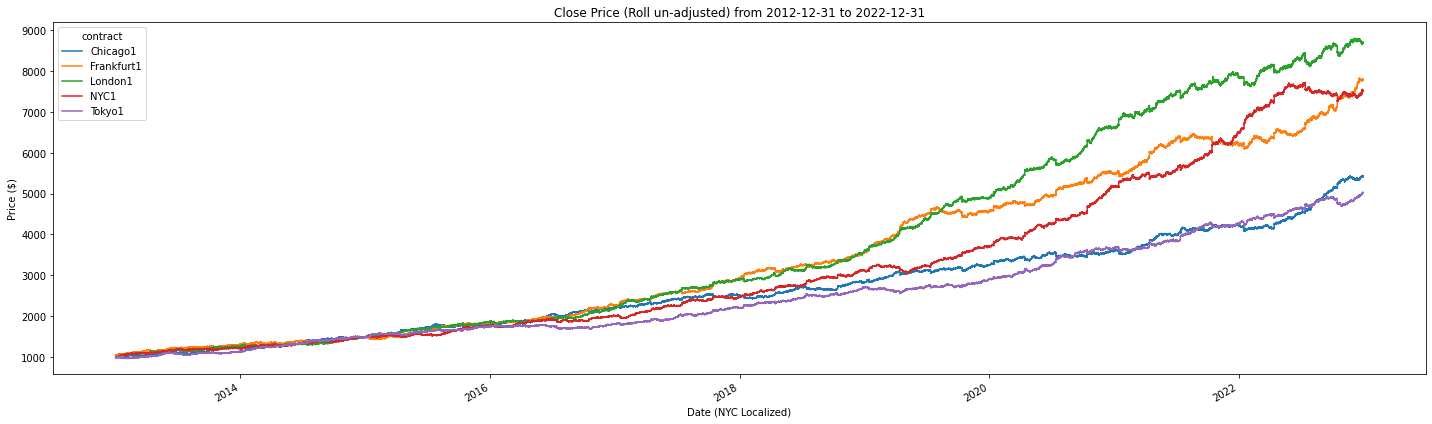

In [7]:
def plot_price(df_price: pd.DataFrame):

    (df_price[
        ["contract_name", "nyc_time", "close_price"]].
        rename(columns = {"contract_name": "contract"}).
        pivot(index = "nyc_time", columns = "contract", values = "close_price").
        fillna(method = "bfill").
        fillna(method = "ffill").
        plot(
            figsize = (20,6),
            ylabel = "Price ($)",
            xlabel = "Date (NYC Localized)",
            title = "Close Price (Roll un-adjusted) from {} to {}".format(
                df_price.nyc_time.min().date(),
                df_price.nyc_time.max().date())))

    plt.tight_layout()
    plt.show()
    
plot_price(df_price)

Simply plot the data and account for the various contracts as they get rolled. In this case use close as the price. Due to the computational strain of plotting 5 min bars for 10yrs the data will be resampled with the first price of each day

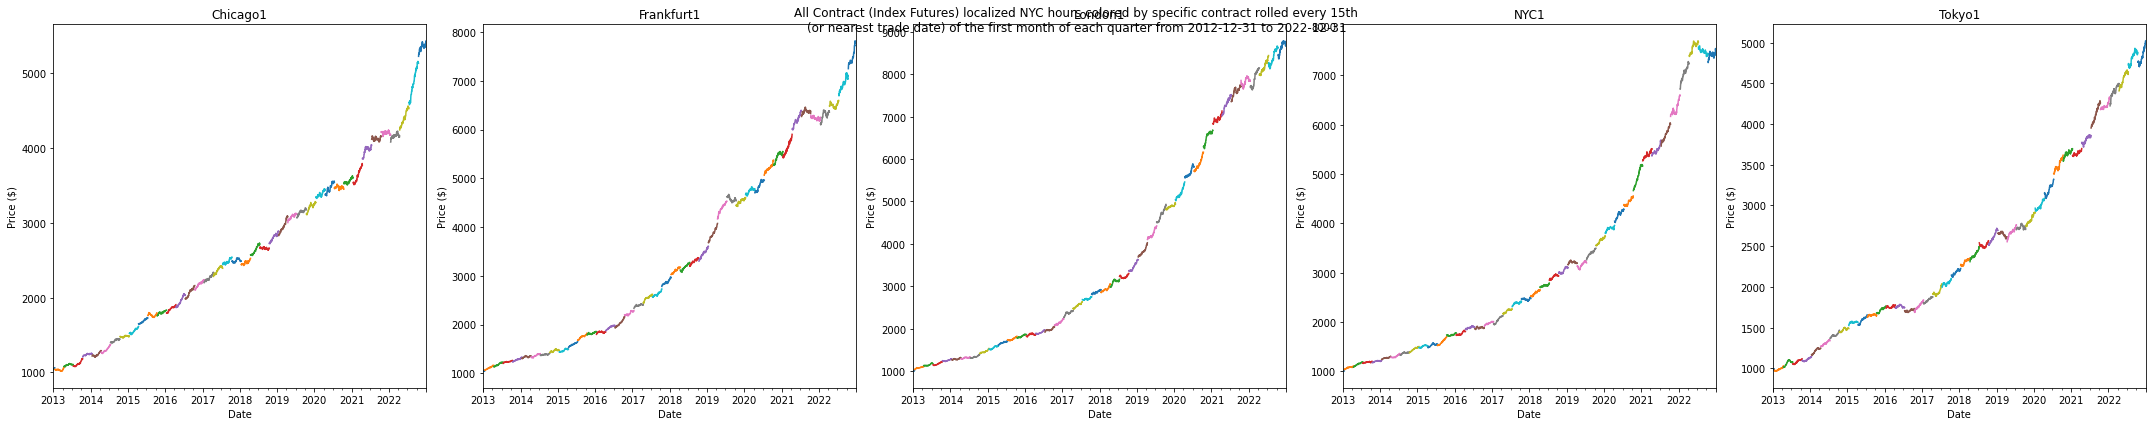

In [8]:
def plot_close_with_roll(df_price: pd.DataFrame):

    contract_names = df_price.contract_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(contract_names), figsize = (30,6))

    for i, contract_name in enumerate(contract_names):

        df_tmp = (df_price.query(
            "contract_name == @contract_name").
            set_index("nyc_time").
            resample("D").
            first())

        contracts = df_tmp.contract.drop_duplicates().to_list()
        for contract in contracts:

            (df_tmp.query(
                "contract == @contract")
                [["close_price"]].
                plot(
                    ax = axes[i],
                    legend = False,
                    title = "{}".format(contract_name),
                    xlabel = "Date",
                    ylabel = "Price ($)"))

    fig.suptitle("All Contract (Index Futures) localized NYC hours colored by specific contract rolled every 15th\n(or nearest trade date) of the first month of each quarter from {} to {}".format(
        df_price.nyc_time.min().date(),
        df_price.nyc_time.max().date()))
    plt.tight_layout()
    plt.show()

plot_close_with_roll(df_price)

In [9]:
rand_date = (df_price.query(
    "weekday == 1 & market_day == 'open'")
    [["local_time", "contract_name"]].
    groupby(["local_time"]).
    head(1).
    reset_index().
    assign(date = lambda x: x.local_time.dt.date).
    sample(frac = 1, random_state = 123).
    head(1).
    date.
    iloc[0])

Make bars

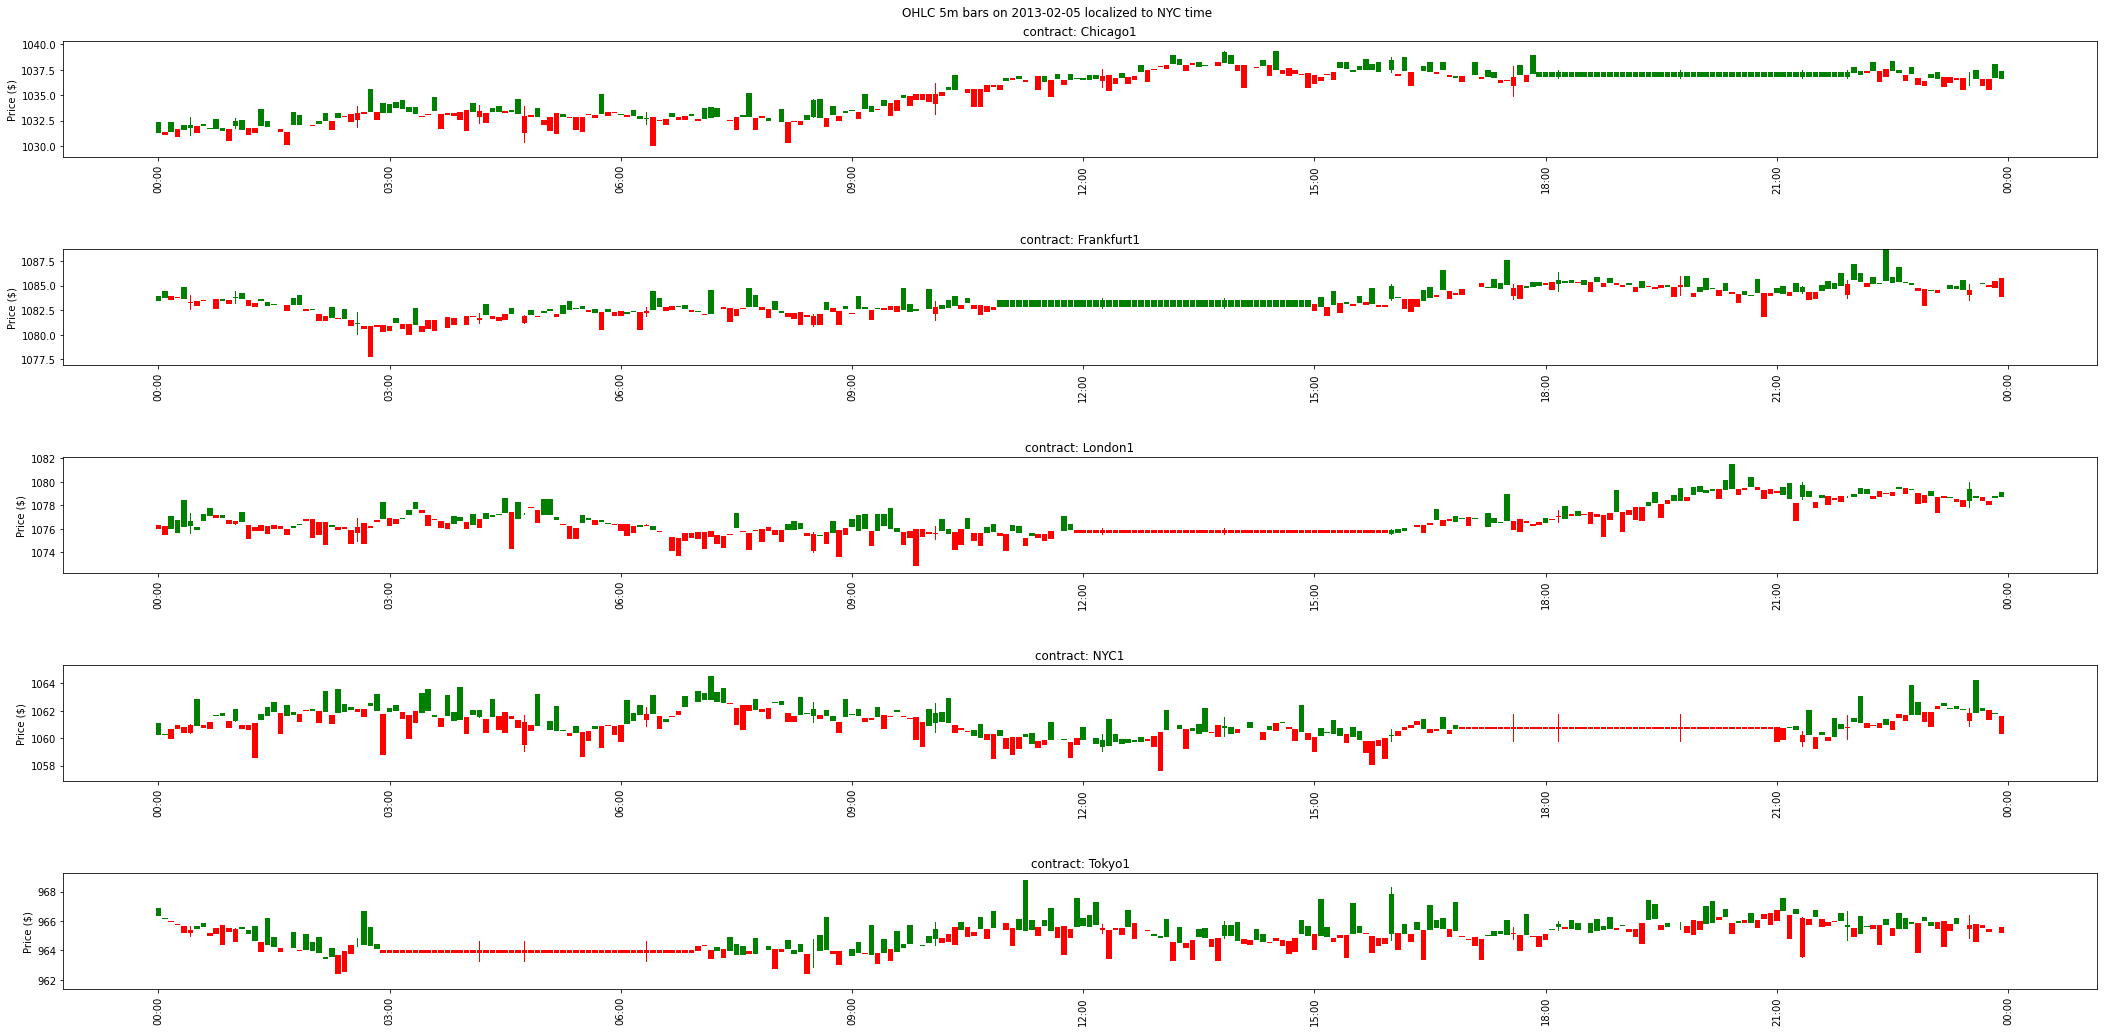

In [10]:
def make_ohlc_bars(df_price: pd.DataFrame, date):

    df_tmp = (df_price.assign(
        date = lambda x: x.nyc_time.dt.date).
        query("date == @rand_date"))

    df_contract = (df_tmp.set_index(
        "nyc_time")
        [["contract_name", "open_price", "high_price", "low_price", "close_price"]])

    contracts = df_contract.contract_name.drop_duplicates().to_list()

    fig, axes = plt.subplots(nrows = len(contracts), figsize = (30,15))
    for i, contract in enumerate(contracts):

        df_plot = (df_contract.query(
            "contract_name == @contract").
            drop(columns = ["contract_name"]))

        df_up = df_plot.query("close_price > open_price")
        df_down = df_plot.query("close_price < open_price")

        width1 = 0.003
        width2 = 0.00003

        axes[i].bar(df_up.index, df_up.close_price - df_up.open_price, width1, bottom = df_up.open_price, color = "green")
        axes[i].bar(df_up.index, df_up.high_price - df_up.close_price, width2, bottom = df_up.close_price, color = "green") 
        axes[i].bar(df_up.index, df_up.low_price - df_up.open_price, width2, bottom = df_up.open_price, color = "green") 

        axes[i].bar(df_down.index, df_down.close_price - df_down.open_price, width1, bottom = df_down.open_price, color = "red")
        axes[i].bar(df_down.index, df_down.high_price - df_down.open_price, width2, bottom = df_down.open_price, color = "red") 
        axes[i].bar(df_down.index, df_down.low_price - df_down.close_price, width2, bottom = df_down.close_price, color = "red") 

        axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        axes[i].tick_params(axis = "x", rotation = 90)
        axes[i].set_title("contract: {}".format(contract))
        axes[i].set_ylabel("Price ($)")

    fig.suptitle("OHLC 5m bars on {} localized to NYC time".format(rand_date))
    plt.tight_layout(pad = 4)

make_ohlc_bars(df_price, rand_date)

# Calculations

## Roll Adjustment

Roll adjustment is calculated by finding which days do roll occurs on (by looking at the specific contract), calculating price returns then zeroing out roll days. Then calcualte cumulative returns without zeroed out roll day, and multiply that series by the contract beginning value to back out roll-adjusted returns. 

In [11]:
def _zero_out_roll(df: pd.DataFrame) -> pd.DataFrame:
    
    df_first = (df.query(
        "local_time == local_time.min()").
        assign(roll_adj = 0))
    
    df_other = (df.query(
        "local_time != local_time.min()").
        assign(roll_adj = lambda x: x.roll_unadj))
    
    df_combined = pd.concat([df_first, df_other])
    return df_combined

def _get_first(df: pd.DataFrame) -> pd.DataFrame: return(df.query("local_time == local_time.min()"))

def _get_roll_adjusted_close(df: pd.DataFrame) -> pd.DataFrame:

    df_rtn_hour = (df[
        ["contract_name", "local_time", "close_price"]].
        pivot(index = "local_time", columns = "contract_name", values = "close_price").
        pct_change().
        reset_index().
        melt(id_vars = "local_time", value_name = "roll_unadj").
        fillna(0).
        merge(
            right = df[["contract_name", "local_time", "contract", "market_hour"]],
            how = "inner",
            on = ["contract_name", "local_time"]))

    df_rtn_open = df_rtn_hour.query("market_hour == 'open'")
    df_rtn_close = df_rtn_hour.query("market_hour == 'close'")

    df_open_roll_adj = (df_rtn_open.groupby(
        "contract").
        apply(_zero_out_roll).
        reset_index(drop = True))

    df_out = pd.concat([df_rtn_close, df_open_roll_adj])

    df_wider = (df_open_roll_adj[
        ["local_time", "contract_name", "roll_unadj", "roll_adj"]].
        melt(id_vars = ["local_time", "contract_name"]).
        assign(contract = lambda x: x.contract_name + "_" + x.variable).
        drop(columns = ["contract_name", "variable"]).
        pivot(index = "local_time", columns = "contract", values = "value"))

    df_cum_longer = (np.cumprod(
        1 + df_wider).
        reset_index().
        melt(id_vars = "local_time").
        assign(
            contract_name = lambda x: x.contract.str.split("_").str[0],
            roll = lambda x: x.contract.str.split("_").str[-1]).
        drop(columns = ["contract"]))

    df_start_prices = (df_price[
        ["contract_name", "local_time", "close_price"]].
        groupby("contract_name").
        apply(_get_first).
        reset_index(drop = True).
        drop(columns = ["local_time"]))

    df_roll_adj = (df_cum_longer.merge(
        right = df_start_prices, how = "inner", on = ["contract_name"]).
        assign(price = lambda x: x.close_price * x.value).
        drop(columns = ["value", "close_price"]).
        pivot(index = ["local_time", "contract_name"], columns = "roll", values = "price").
        reset_index())
    
    return df_roll_adj

def get_roll_adjusted_close(df: pd.DataFrame) -> pd.DataFrame:
    
    return(df.groupby([
        "contract_name"]).
        apply(_get_roll_adjusted_close).
        reset_index(drop = True))

def plot_roll_adjusted_close(df: pd.DataFrame, figssize: tuple = (30,6)):
    
    df_roll_adj = get_roll_adjusted_close(df_price)
    contracts = df_roll_adj.contract_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(contracts), figsize = figssize)

    for i, contract in enumerate(contracts):

        (df_roll_adj.query(
            "contract_name == @contract").
            set_index("local_time").
            rename(columns = {
                "adj": "Adjusted",
                "unadj": "Unadjusted"}).
            plot(
                ax = axes[i],
                title = contract,
                ylabel = "Price ($)",
                xlabel = "NYC Time"))

    fig.suptitle("Plotting Roll Adjusted vs. Roll Unadjusted Close Price from {} to {}".format(
        df_roll_adj.local_time.min().date(),
        df_roll_adj.local_time.max().date()))

    plt.tight_layout(pad = 3)
    plt.show()

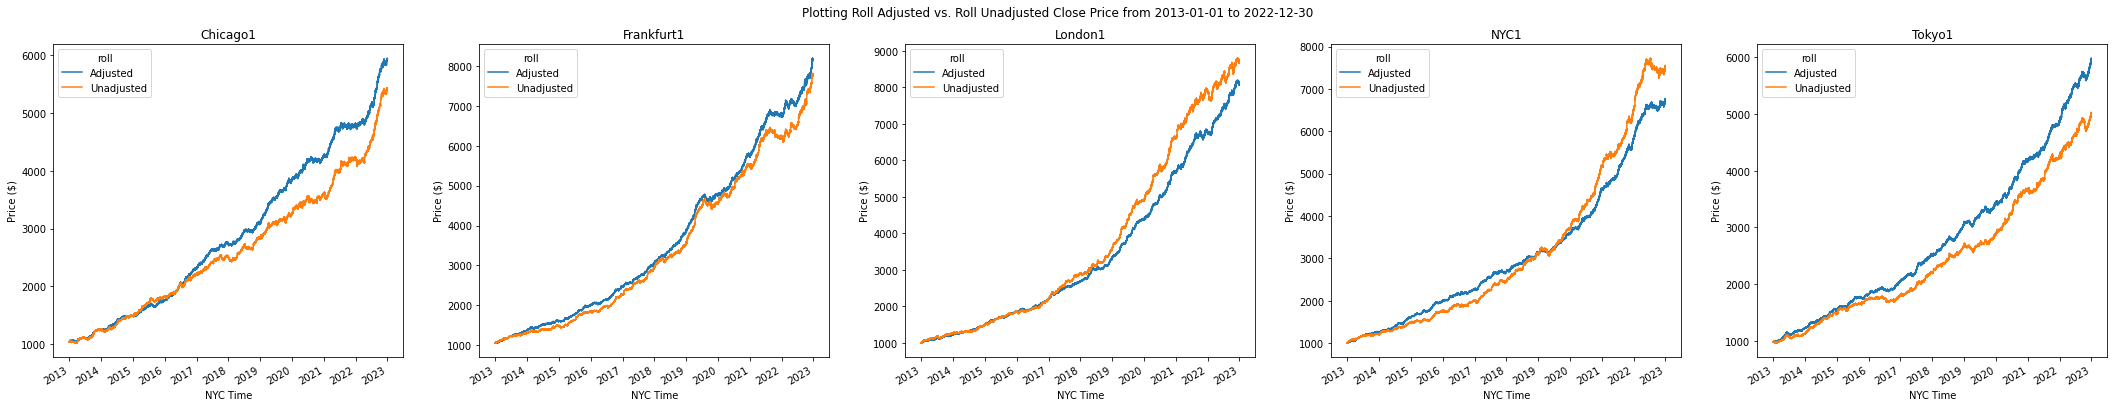

In [12]:
plot_roll_adjusted_close(df_price)
df_roll_adj = get_roll_adjusted_close(df_price)

Look at first year to see specific jumps

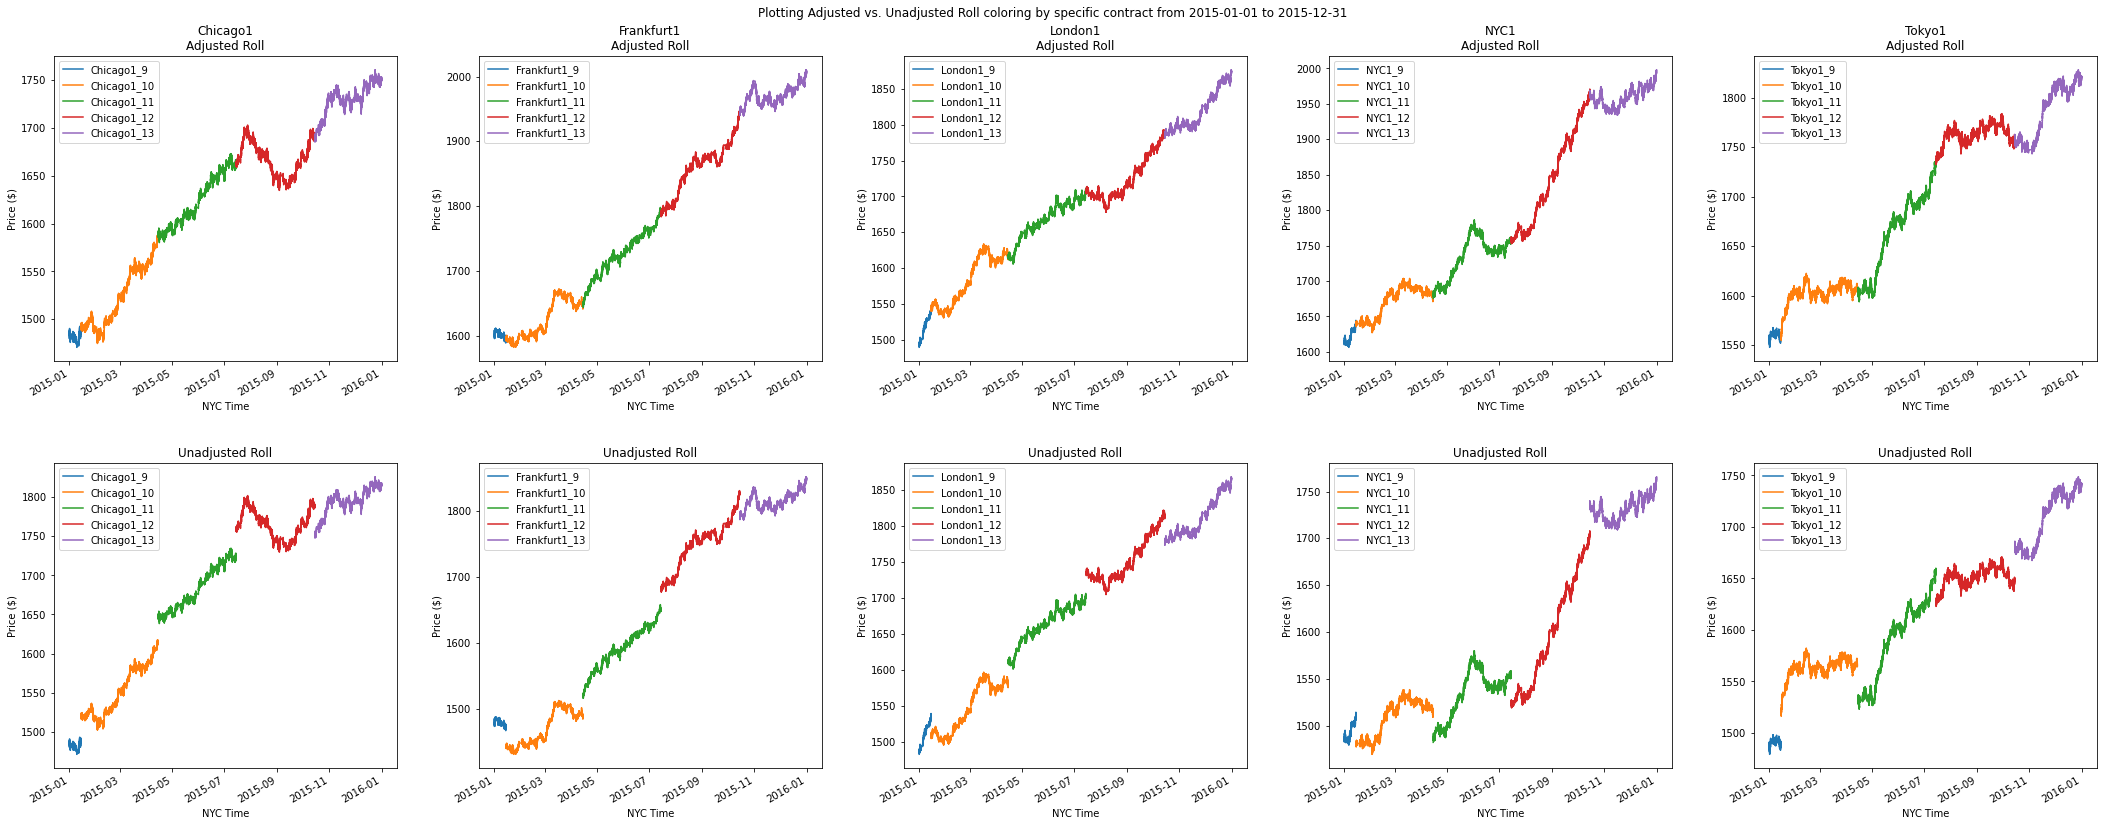

In [13]:
def plot_specific_roll(df_roll_adj: pd.DataFrame, year: int):

    df_roll_year_spef = (df_roll_adj.assign(
        date = lambda x: pd.to_datetime(x.local_time.dt.date),
        year = lambda x: x.date.dt.year).
        query("year == @year").
        drop(columns = ["date", "year"]))

    df_roll_contract_name = df_roll_year_spef.merge(
        right = df_price[["local_time", "contract_name", "contract"]],
        how = "inner",
        on = ["local_time", "contract_name"])

    contracts = df_roll_year_spef.contract_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(contracts), nrows = 2, figsize = (30,12))

    for i, contract in enumerate(contracts):

        df_contract = (df_roll_contract_name.query(
            "contract_name == @contract").
            drop(columns = ["contract_name"]))  

        spef_contracts = df_contract.contract.drop_duplicates().to_list()
        for spef_contract in spef_contracts:

            df_spef_contract = (df_contract.query(
                "contract == @spef_contract").
                drop(columns = ["contract"]).
                set_index("local_time"))

            (df_spef_contract[
                ["adj"]].
                rename(columns = {"adj": spef_contract}).
                plot(
                    ax = axes[0,i],
                    title = "{}\nAdjusted Roll".format(contract),
                    xlabel = "NYC Time",
                    ylabel = "Price ($)"))

            (df_spef_contract[
                ["unadj"]].
                rename(columns = {"unadj": spef_contract}).
                plot(
                    ax = axes[1,i],
                    title = "Unadjusted Roll",
                    xlabel = "NYC Time",
                    ylabel = "Price ($)"))


    fig.suptitle("Plotting Adjusted vs. Unadjusted Roll coloring by specific contract from {} to {}".format(
        df_roll_contract_name.local_time.min().date(),
        df_roll_contract_name.local_time.max().date()))

    plt.tight_layout(pad = 3.5)
    plt.show()
    
plot_specific_roll(df_roll_adj, 2015)

## Average Buy Sell Volume Per Each Day

In [14]:
def get_summed_daily_volume(df_price: pd.DataFrame) -> pd.DataFrame:

    daily_vol = (df_price[
        ["contract_name", "local_time", "buy_vol", "sell_vol", "market_hour"]].
        query("market_hour == 'open'").
        assign(date = lambda x: x.local_time.dt.date).
        drop(columns = ["local_time", "market_hour"]).
        groupby(["contract_name", "date"]).
        agg("sum").
        reset_index())
    
    return daily_vol

def get_avg_volume(df_price: pd.DataFrame) -> pd.DataFrame:

    daily_vol = get_summed_daily_volume(df_price)
    df_out = (daily_vol.drop(
        columns = ["date"]).
        groupby("contract_name").
        agg("mean"))
    
    return df_out

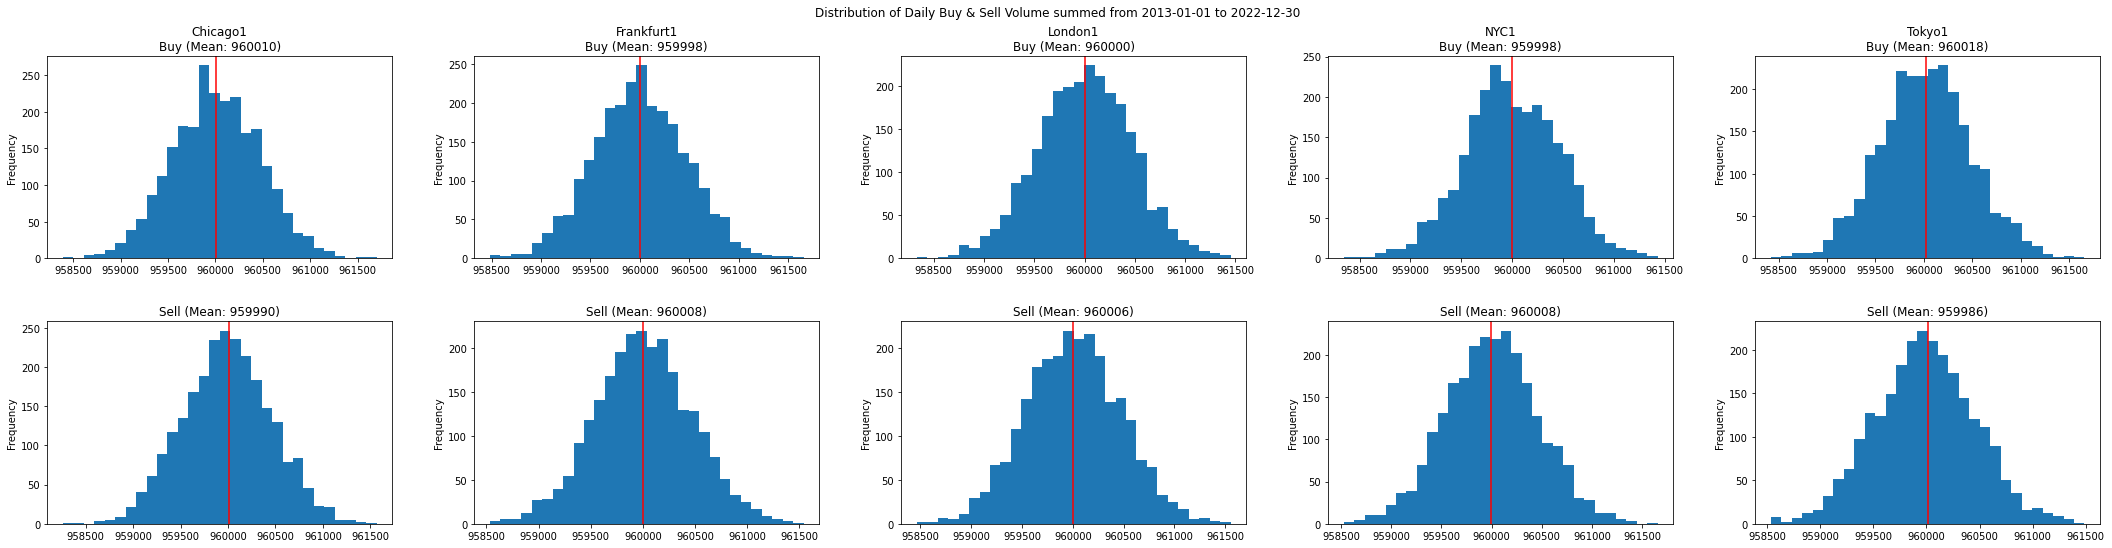

In [15]:
def plot_daily_vol_hist(df_price: pd.DataFrame):

    daily_volume = get_summed_daily_volume(df_price)
    contracts = daily_volume.contract_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(contracts), nrows = 2, figsize = (30,8))

    for i, contract in enumerate(contracts):

        df_tmp = (daily_volume.query(
            "contract_name == @contract & date != date.min()").
            drop(columns = ["contract_name"]).
            set_index("date"))

        buy_vol_mean = df_tmp["buy_vol"].mean()
        df_tmp["buy_vol"].plot(
            ax = axes[0,i], 
            kind = "hist", 
            title = "{}\nBuy (Mean: {})".format(contract, round(buy_vol_mean)), 
            bins = 30,
            xlabel = "Volume")
        
        axes[0,i].axvline(buy_vol_mean, color = "red")

        sell_vol_mean = df_tmp["sell_vol"].mean()
        df_tmp["sell_vol"].plot(
            ax = axes[1,i], 
            kind = "hist", 
            bins = 30,
            xlabel = "Volume",
            title = "Sell (Mean: {})".format(round(sell_vol_mean)))
        
        axes[1,i].axvline(buy_vol_mean, color = "red")

    fig.suptitle("Distribution of Daily Buy & Sell Volume summed from {} to {}".format(
        daily_volume.date.min(),
        daily_volume.date.max()))

    plt.tight_layout(pad = 3)
    plt.show()
    
plot_daily_vol_hist(df_price)

/Applications/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


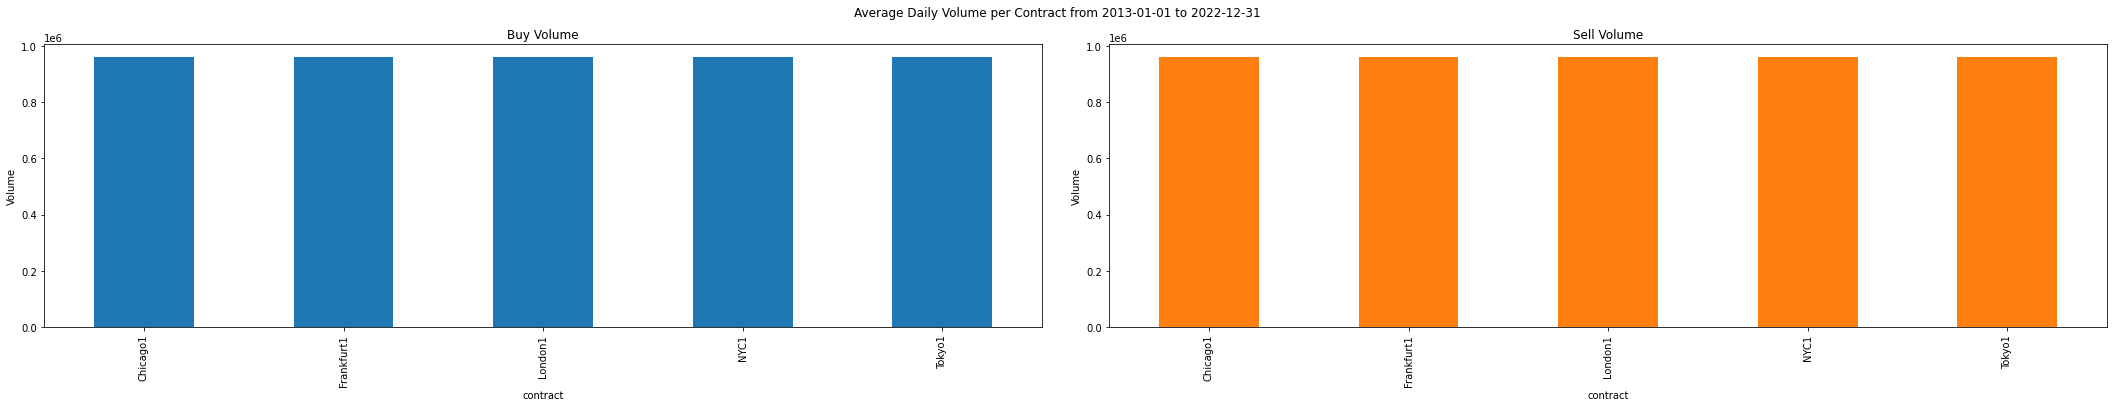

In [16]:
def plot_avg_vol_bar(df_price: pd.DataFrame):

    avg_volume = get_avg_volume(df_price)
    fig, axes = plt.subplots(figsize = (30,6))

    (avg_volume.
        rename(columns = {
            "buy_vol": "Buy Volume", 
            "sell_vol": "Sell Volume"}).
        plot(
            kind = "bar", 
            subplots = True, 
            legend = False, 
            layout = (1,2), 
            ax = axes,
            ylabel = "Volume", 
            xlabel = "contract"))

    fig.suptitle("Average Daily Volume per Contract from {} to {}".format(
        df_price.local_time.min().date(),
        df_price.local_time.max().date()))

    plt.tight_layout(pad = 3)
    plt.show()
    
plot_avg_vol_bar(df_price)

In [17]:
daily_volume = get_summed_daily_volume(df_price)
avg_volume = get_avg_volume(df_price)

## Finding Average Intraday return per period NYC time

Described as "what is the average daily return of all contracts between the 9:00am and 12:00pm NYC hour for adjusted close". This will be done by slicing time to specific hours and then calculating returns. This is done by querying for all nyc open days, then querying for specific hours then grabbing first and last bar of the date range and then calculating return. That yields the daily return between for that specific intraday time range. Then to get average just group by each day and contract and calculate average. 

In [ ]:
def _get_min_max_date(df: pd.DataFrame) -> pd.DataFrame: return(df.query("nyc_time == nyc_time.max() | nyc_time == nyc_time.min()").drop_duplicates())

def _get_rtn(df: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df.drop(
        columns = ["date"]).
        pivot(index = "nyc_time", columns = "contract_name", values = "adj").
        pct_change().
        dropna().
        reset_index().
        melt(id_vars = "nyc_time"))
    
    return(df_out)

def get_avg_intraday_nyc_rtn(
    df_price: pd.DataFrame,
    nyc_hour1: int = 9,
    nyc_hour2: int = 12) -> pd.DataFrame:

    if nyc_hour1 > nyc_hour2: raise ValueError("nyc_hour1 must be less than nyc_hour2")

    df_roll_adj = get_roll_adjusted_close(df_price)
    df_min_max = (df_roll_adj.merge(
        right = df_price.query("zone == 'NYC'")[["nyc_time", "market_hour", "local_time"]],
        how = "inner",
        on = "local_time").
        drop(columns = ["local_time"]).
        query("market_hour == 'open'").
        assign(
            date = lambda x: x.nyc_time.dt.date,
            hour = lambda x: x.nyc_time.dt.hour).
        query("hour >= @nyc_hour1 & hour < @nyc_hour2")
        [["date", "contract_name", "adj", "nyc_time"]].
        groupby(["date", "contract_name"]).
        apply(_get_min_max_date).
        reset_index(drop = True))

    df_rtn = (df_min_max.groupby(
        ["date", "contract_name"]).
        apply(_get_rtn).
        drop(columns = ["contract_name", "nyc_time"]).
        reset_index().
        drop(columns = ["level_2"]))

    df_mean = df_rtn.drop(columns = ["date"]).groupby("contract_name").mean() * 100
    return df_mean

def plot_avg_intraday_nyc_rtn(
    df_price: pd.DataFrame,
    nyc_hour1: int = 9,
    nyc_hour2: int = 12):
    
    df_mean = get_avg_intraday_nyc_rtn(
        df_price = df_price, 
        nyc_hour1 = nyc_hour1,
        nyc_hour2 = nyc_hour2)

    (df_mean.sort_values(
        "value").
        plot(
            kind = "bar",
            legend = False,
            xlabel = "Contract",
            ylabel = "Return (%)",
            figsize = (12,6),
            title = "Average 5 minute Intraday Return between NYC {}:00 and {}:00 from {} to {}".format(
                nyc_hour1,
                nyc_hour2,
                df_price.nyc_time.min().date(),
                df_price.nyc_time.max().date())))

    plt.tight_layout()
    plt.show()

df_mean = get_avg_intraday_nyc_rtn(df_price)
plot_avg_intraday_nyc_rtn(df_price)

In [ ]:
def get_intraday_nyc_rtn(
    df_price: pd.DataFrame,
    nyc_hour1: int = 9,
    nyc_hour2: int = 12) -> pd.DataFrame:

    if nyc_hour1 > nyc_hour2: raise ValueError("nyc_hour1 must be less than nyc_hour2")

    df_roll_adj = get_roll_adjusted_close(df_price)
    df_min_max = (df_roll_adj.merge(
        right = df_price.query("zone == 'NYC'")[["nyc_time", "market_hour", "local_time"]],
        how = "inner",
        on = ["local_time"]).
        drop(columns = ["local_time"]).
        query("market_hour == 'open'").
        assign(
            date = lambda x: x.nyc_time.dt.date,
            hour = lambda x: x.nyc_time.dt.hour).
        query("hour >= @nyc_hour1 & hour < @nyc_hour2")
        [["date", "contract_name", "adj", "nyc_time"]].
        groupby(["date", "contract_name"]).
        apply(_get_min_max_date).
        reset_index(drop = True))

    df_rtn = (df_min_max.groupby(
        ["date", "contract_name"]).
        apply(_get_rtn).
        drop(columns = ["contract_name", "nyc_time"]).
        reset_index().
        drop(columns = ["level_2"]))
    
    return df_rtn

In [ ]:
def plot_intraday_nyc_rtn(
    df_price: pd.DataFrame,
    nyc_hour1: int = 9,
    nyc_hour2: int = 12) -> pd.DataFrame:    
    
    df_rtn = get_intraday_nyc_rtn(df_price = df_price, nyc_hour1 = nyc_hour1, nyc_hour2 = nyc_hour2)

    contracts = df_rtn.contract_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(contracts), figsize = (30,6))

    for i, contract in enumerate(contracts):

        df_tmp = (df_rtn.query(
            "contract_name == @contract").
            drop(columns = ["contract_name"]).
            set_index("date"))

        df_tmp = df_tmp * 100

        (df_tmp.plot(
            ax = axes[i],
            legend = False,
            kind = "hist",
            bins = 30))

        mean_rtn = df_tmp.mean().iloc[0]

        axes[i].axvline(mean_rtn, color = "red")
        axes[i].set_xlabel("Return (%)")
        axes[i].set_title("{} Mean: {}".format(contract, round(mean_rtn, 2)))

    fig.suptitle("Daily 5 minute Intraday returns from {}:00 to {}:00 NYC hours from {} to {}".format(
        nyc_hour1, 
        nyc_hour2,
        df_price.nyc_time.min().date(),
        df_price.nyc_time.max().date()))
    
    plt.tight_layout(pad = 3)
    plt.show()
    
plot_intraday_nyc_rtn(df_price)

## Getting all roll adjusted prices

Getting all roll adjusted prices just involves getting the difference between roll adjusted and roll un-adjusted and adding that difference to all of the other prices. By proxy this calculates the roll cost and cumulative roll PnL

In [ ]:
def get_roll_adjusted_prices(df_price: pd.DataFrame) -> pd.DataFrame:
    
    df_roll_adj = get_roll_adjusted_close(df_price)

    df_spread = (df_roll_adj.assign(
        spread = lambda x: x.adj- x.unadj).
        drop(columns = ["adj", "unadj"]))

    df_prices_adj = (df_price[
        ["contract_name", "local_time", "open_price", "high_price", "low_price", "close_price"]].
        melt(id_vars = ["contract_name", "local_time"], var_name = "field").
        merge(right = df_spread, how = "inner", on = ["local_time", "contract_name"]).
        assign(adj = lambda x: x.spread + x.value).
        drop(columns = ["spread"]).
        rename(columns = {"value": "unadj"}))
    
    return df_prices_adj

df_price_adj = get_roll_adjusted_prices(df_price)

## Finding Average Intraday True Range

In [ ]:
def get_intraday_price_range(df_price: pd.DataFrame) -> pd.DataFrame:

    df_price_adj = get_roll_adjusted_prices(df_price)
    
    df_range = (df_price_adj.query(
        "field != 'open_price'").
        melt(id_vars = ["contract_name", "local_time", "field"], var_name = "roll").
        pivot(index = ["contract_name", "local_time", "roll"], columns = ["field"], values = "value").
        reset_index().
        assign(price_range = lambda x: (x.high_price - x.low_price) / x.close_price).
        drop(columns = ["close_price", "high_price", "low_price"]).
        merge(
            right = df_price[["contract_name", "local_time", "market_hour"]], 
            how = "inner", on = ["contract_name", "local_time"]).
        query("market_hour == 'open'").
        drop(columns = ["market_hour"]))

    return df_range

df_range = get_intraday_price_range(df_price)

In [ ]:
def plot_intraday_price_range_hist(df_price: pd.DataFrame):

    df_intraday_range = get_intraday_price_range(df_price)

    (df_intraday_range.drop(
        columns = ["local_time"]).
        groupby(["contract_name", "roll"]).
        agg("mean").
        reset_index().
        pivot(index = ["contract_name"], columns = "roll", values = "price_range").
        rename(columns = {
            "adj": "Adjusted", 
            "unadj": "Unadjutsted"}).
        plot(
            kind = "bar",
            ylabel = "True Range",
            xlabel = "Contract Name",
            figsize = (20,6),
            title = "Average True Range 5 minute bars of Roll Adjusted and Roll Unadjusted from {} to {}".format(
                df_price.local_time.min().date(),
                df_price.local_time.max().date())).
        legend(loc = "upper left"))

    plt.tight_layout()
    plt.show()
    
plot_intraday_price_range_hist(df_price)

In [ ]:
def plot_intraday_range_hist(df_price: pd.DataFrame): 

    df_intraday_range = get_intraday_price_range(df_price)
    contracts = df_intraday_range.contract_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(contracts), nrows = 2, figsize = (30,12))

    for i, contract in enumerate(contracts):

        df_tmp = (df_intraday_range.query(
            "contract_name == @contract").
            drop(columns = ["contract_name"]))

        df_tmp_wider = (df_tmp.pivot(
            index = "local_time", columns = "roll", values = "price_range").
            rename(columns = {
                "adj": "Adjusted",
                "unadj": "Unadjusted"}))

        df_adj_mean, df_unadj_mean = df_tmp_wider["Adjusted"].mean(), df_tmp_wider["Unadjusted"].mean()

        (df_tmp_wider[
            ["Unadjusted"]].
            plot(
                kind = "hist",
                ax = axes[0,i],
                xlabel = "True Range",
                legend = False,
                bins = 30,
                title = "{}\n Unadjusted (Mean: {})".format(
                    contract,
                    round(df_unadj_mean,4))))

        axes[0,i].axvline(df_unadj_mean, color = "r")

        (df_tmp_wider[
            ["Adjusted"]].
            plot(
                kind = "hist",
                ax = axes[1,i],
                bins = 30,
                xlabel = "True Range",
                legend = False,
                title = "Adjusted (Mean: {})".format(
                    round(df_adj_mean, 4))))

        axes[1,i].axvline(df_adj_mean, color = "r")

    fig.suptitle("Intraday 5 minute True range from Roll Adjusted and Roll Unadjsted from {} to {}".format(
        df_price.local_time.min().date(),
        df_price.local_time.max().date()))

    plt.tight_layout(pad = 3)
    plt.show()
    
plot_intraday_range_hist(df_price)

## Resampling to daily.

Since it may be significant to get average true range for the trading session a daily price time series is needed, and an analog true range will be written. Unfortunately it is not as simple as using ```pd.resample``` for day and getting first or last. The function will group by date and contract and get the open, high, and close. When resampling to daily its not possible to back out returns per a specific time zone trading session. An analog to average return between two periods will be made below

In [ ]:
def _get_first_date(df: pd.DataFrame) -> pd.DataFrame: return(df.query("local_time == local_time.min()"))
def _get_last_date(df: pd.DataFrame) -> pd.DataFrame: return(df.query("local_time == local_time.max()"))

def resample_bars_daily(df_price: pd.DataFrame) -> pd.DataFrame:

    df_price_adj = get_roll_adjusted_prices(df_price)

    df_price_adj_longer = (df_price_adj.melt(
        id_vars = ["contract_name", "local_time", "field"], var_name = "roll").
        assign(date = lambda x: x.local_time.dt.date))

    print("Working on Open")
    df_open = (df_price_adj_longer.query(
        "field == 'open_price'").
        drop(columns = ["field"]).
        groupby(["contract_name", "roll", "date"]).
        apply(_get_first_date).
        reset_index(drop = True).
        rename(columns = {"value": "open_price"}).
        drop(columns = ["local_time"]))

    print("Working on Close")
    df_close = (df_price_adj_longer.query(
        "field == 'close_price'").
        drop(columns = ["field"]).
        groupby(["contract_name", "roll", "date"]).
        apply(_get_last_date).
        reset_index(drop = True).
        rename(columns = {"value": "close_price"}).
        drop(columns = ["local_time"]))

    print("Working on High")
    df_high = (df_price_adj_longer.query(
        "field == 'high_price'").
        drop(columns = ["field", "local_time"]).
        groupby(["contract_name", "roll", "date"]).
        agg("max")
        ["value"].
        reset_index().
        rename(columns = {"value": "high_price"}))

    print("Working on Low")
    df_low = (df_price_adj_longer.query(
        "field == 'low_price'").
        drop(columns = ["field", "local_time"]).
        groupby(["contract_name", "roll", "date"]).
        agg("min")
        ["value"].
        reset_index().
        rename(columns = {"value": "low_price"}))

    df_combined = (df_open.merge(
        right = df_close, how = "inner", on = ["contract_name", "roll", "date"]).
        merge(right = df_high, how = "inner", on = ["contract_name", "roll", "date"]).
        merge(right = df_low, how = "inner", on = ["contract_name", "roll", "date"]).
        rename(columns = {"date": "local_date"}))
    
    return df_combined

df_daily_bar = resample_bars_daily(df_price)

## Average True Range over local trading session

In [ ]:
def get_daily_true_range(df_price: pd.DataFrame) -> pd.DataFrame:
    
    df_daily_bar = resample_bars_daily(df_price)
    df_true_range = (df_daily_bar.assign(
        price_range = lambda x: (x.high_price - x.low_price) / x.close_price).
        drop(columns = ["close_price", "high_price", "low_price", "open_price"]))
    
    return df_true_range

df_daily_true_range = get_daily_true_range(df_price)

In [ ]:
def get_avg_daily_true_range(df_price: pd.DataFrame) -> pd.DataFrame:
    
    df_true_range = get_daily_true_range(df_price)
    df_out = (df_true_range.drop(
        columns = ["local_date"]).
        groupby(["contract_name", "roll"]).
        agg("mean")
        ["price_range"].
        reset_index().
        pivot(index = "contract_name", columns = "roll", values = "price_range"))
    
    return df_out

df_avg_daily_true_range = get_avg_daily_true_range(df_price)

In [ ]:
def plot_daily_avg_true_range(df_price):

    df_true_range = get_daily_true_range(df_price)

    df_avg_daily_true_range = (df_true_range.drop(
            columns = ["local_date"]).
            groupby(["contract_name", "roll"]).
            agg("mean")
            ["price_range"].
            reset_index().
            pivot(index = "contract_name", columns = "roll", values = "price_range"))

    (df_avg_daily_true_range.rename(
        columns = {
            "adj": "Adjusted",
            "unadj": "Unadjusted"}).
        plot(
            kind = "bar",
            figsize = (12,6),
            ylabel = "True Range",
            xlabel = "Contract Name",
            title = "Daily (localalized to local time) true range from {} to {}".format(
                df_price.local_time.min().date(),
                df_price.local_time.max().date())).
        legend(loc = "upper left"))

    plt.tight_layout()
    plt.show()
    
plot_daily_avg_true_range(df_price)